# Causality Analysis on Wages of World Soccer Players

Final project for the course CS7290 at Northeastern Univerisity @ Fall 2020

by Jie Xiao, Yik Lung Chan

## Introduction

Football players' salaries have been one of the hot topics among football fans over the years. Our study was conducted to explore the factors that significantly influence the football players' salary. We explored factors like player's club tier, positions in a team, age, weight, height, international reputation score, potential score, and a consortium of performance statistics (ex. pace, dribbling, defending, attacking_crossing, attacking_finishing, attacking_heading_accuracy, ect.). Our data including all the salaries data of most football players from 2015 to 2019. The main goal of the study is explore the factors that influence salary of players and try to build a causal inference model for soccer club managers to leverage as a tool to evaluate player values.

From our intuition and after consulting friends who are super football funs, football players salary depends on several main factors: age, player's international reputation, club tier, positions, all the statistics which can represents the players' performances, players' demographic datas which including weight, height ect.
We draw the DAG using 'pyplot' and 'networkx' package to show our assumptions of the causal effects

## Library & Data Imports

### Import Nessasary Libraries

In [2]:
!pip install pyro-ppl
!pip install pgmpy
!apt install tree

     |████████████████████████████████| 614kB 8.5MB/s 
     |████████████████████████████████| 327kB 8.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (95.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
import math
import pyro
import torch
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions as dist
import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.models import BayesianModel
from pyro.infer import Importance, EmpiricalMarginal
from IPython.display import display


#disable warnings
pd.options.mode.chained_assignment = None  

### Load Data Files From Google Drive

In [4]:

from google.colab import drive
drive.mount('/content/drive')

# Show structure of data folder
!tree '/content/drive/MyDrive/CS7290 Final Project/data'

Mounted at /content/drive
/content/drive/MyDrive/CS7290 Final Project/data
├── missing_and_found_tiers.csv
├── missing_and_found_tiers.gsheet
├── players_15.csv
├── players_16.csv
├── players_17.csv
├── players_18.csv
├── players_19.csv
├── players_20.csv
├── teams_and_leagues.csv
└── tiers.csv

0 directories, 10 files


In [5]:
data_path = "/content/drive/MyDrive/CS7290 Final Project/data/"
data_files = [f"players_{year}.csv" for year in (16,17,18,19)]

#show columns of raw data
columns = pd.read_csv(data_path + data_files[0]).columns.tolist()
for i,name in enumerate(columns, 1):
    print('{0: <25}'.format(name), end='\n' if i % 5 == 0 else '\t')

sofifa_id                	player_url               	short_name               	long_name                	age                      
dob                      	height_cm                	weight_kg                	nationality              	club                     
overall                  	potential                	value_eur                	wage_eur                 	player_positions         
preferred_foot           	international_reputation 	weak_foot                	skill_moves              	work_rate                
body_type                	real_face                	release_clause_eur       	player_tags              	team_position            
team_jersey_number       	loaned_from              	joined                   	contract_valid_until     	nation_position          
nation_jersey_number     	pace                     	shooting                 	passing                  	dribbling                
defending                	physic                   	gk_diving                	gk_handling 

### Read csv data as pandas DataFrame



In [6]:
basic_info = ["club", "player_positions", "work_rate", "joined", "international_reputation"]
body = ["age", "height_cm", "weight_kg", "physic"]
moneytary_values = ["wage_eur"]
ratings = ["overall", "potential"]
stats = [
            "pace",
            "dribbling",
            "defending",
            "attacking_crossing",
            "attacking_finishing",
            "attacking_heading_accuracy",
            "attacking_short_passing",
            "attacking_volleys",
            "skill_dribbling",
            "skill_curve",
            "skill_fk_accuracy",
            "skill_long_passing",
            "skill_ball_control",
            "movement_acceleration",
            "movement_sprint_speed",
            "movement_agility",
            "movement_reactions",
            "movement_balance",
            "power_shot_power",
            "power_jumping",
            "power_stamina",
            "power_strength",
            "power_long_shots",
            "mentality_aggression",
            "mentality_interceptions",
            "mentality_positioning",
            "mentality_vision",
            "mentality_penalties",
            "mentality_composure",
            "defending_marking",
            "defending_standing_tackle",
            "defending_sliding_tackle",
            "goalkeeping_diving",
            "goalkeeping_handling",
            "goalkeeping_kicking",
            "goalkeeping_positioning",
            "goalkeeping_reflexes"
]

gaussian_distributed = [*body, *ratings, *stats]
log_linear_distributed = [*moneytary_values, "joined"]

In [7]:
df_list = []

for f in data_files:
    df_list.append(pd.read_csv(
        data_path + f, 
        usecols = [*basic_info, *body, *moneytary_values, *ratings, *stats]
    ))

df = pd.concat(df_list, axis=0, ignore_index=True)

numeric_columns = [*body, *gaussian_distributed, *moneytary_values, "international_reputation"]
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df = df.dropna()

#show raw data
df

,age,height_cm,weight_kg,club,overall,potential,wage_eur,player_positions,international_reputation,work_rate,joined,pace,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
14893,28,172,74,Manchester City,89,89,210000,ST,4,High/Medium,2011-07-28,89.0,89.0,23.0,70.0,70.0,90.0,68.0,79.0,85.0,89.0,82.0,72.0,63.0,89.0,92.0,86.0,86.0,88.0,90.0,87.0,80.0,74.0,73.0,84.0,57.0,24.0,91.0,83.0,83.0,90.0,13.0,20.0,12.0,13.0,15.0,6.0,11.0,14.0
14895,31,183,79,Paris Saint-Germain,89,89,160000,CB,4,High/High,2012-07-01,74.0,73.0,90.0,79.0,60.0,38.0,82.0,79.0,63.0,68.0,61.0,73.0,81.0,80.0,72.0,76.0,75.0,84.0,68.0,78.0,93.0,74.0,81.0,71.0,77.0,91.0,59.0,74.0,71.0,80.0,90.0,91.0,89.0,9.0,12.0,5.0,9.0,10.0
14899,25,181,76,Manchester City,88,91,160000,"CAM, RM, LM",4,High/Medium,2015-08-30,77.0,84.0,40.0,75.0,90.0,82.0,53.0,88.0,82.0,85.0,78.0,77.0,82.0,86.0,76.0,78.0,78.0,87.0,75.0,84.0,65.0,85.0,73.0,85.0,68.0,52.0,83.0,88.0,77.0,82.0,30.0,39.0,40.0,15.0,13.0,5.0,10.0,13.0
14931,31,168,66,Arsenal,86,86,130000,"CAM, CM, CDM",3,Medium/Medium,2012-08-07,71.0,86.0,57.0,64.0,85.0,77.0,58.0,86.0,72.0,86.0,86.0,78.0,84.0,87.0,77.0,66.0,85.0,85.0,91.0,78.0,71.0,72.0,60.0,82.0,64.0,55.0,82.0,85.0,80.0,88.0,56.0,62.0,48.0,6.0,9.0,5.0,7.0,15.0
14949,27,187,78,Paris Saint-Germain,85,86,130000,"CM, LW, RW",3,High/Medium,2011-08-01,74.0,86.0,58.0,68.0,78.0,75.0,63.0,87.0,78.0,89.0,83.0,69.0,83.0,87.0,72.0,75.0,85.0,84.0,58.0,78.0,49.0,75.0,68.0,78.0,65.0,69.0,81.0,88.0,75.0,75.0,49.0,59.0,51.0,14.0,9.0,6.0,10.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67247,19,180,72,Cork City,47,61,1000,"CM, CDM",1,Medium/Medium,2017-01-01,52.0,45.0,46.0,49.0,31.0,26.0,49.0,55.0,31.0,44.0,30.0,31.0,50.0,41.0,55.0,49.0,51.0,53.0,65.0,46.0,60.0,44.0,49.0,28.0,51.0,49.0,31.0,51.0,40.0,35.0,41.0,44.0,53.0,11.0,6.0,13.0,11.0,8.0
67248,18,178,75,SpVgg Unterhaching,47,61,1000,ST,1,Medium/Medium,2017-07-01,64.0,52.0,23.0,53.0,37.0,48.0,30.0,45.0,43.0,50.0,41.0,38.0,30.0,51.0,62.0,66.0,67.0,39.0,70.0,38.0,81.0,55.0,60.0,35.0,28.0,25.0,43.0,41.0,48.0,37.0,28.0,15.0,22.0,15.0,5.0,14.0,12.0,8.0
67249,20,181,64,Guangzhou R&F FC,47,61,1000,CM,1,Medium/Medium,2017-01-01,81.0,49.0,44.0,52.0,40.0,27.0,45.0,58.0,35.0,46.0,39.0,37.0,47.0,42.0,84.0,78.0,78.0,45.0,70.0,48.0,59.0,58.0,45.0,35.0,58.0,41.0,48.0,40.0,36.0,39.0,54.0,37.0,40.0,5.0,12.0,14.0,14.0,11.0
67250,19,179,73,SpVgg Unterhaching,47,59,1000,RB,1,High/Medium,2017-07-01,63.0,50.0,41.0,56.0,39.0,40.0,45.0,46.0,42.0,46.0,35.0,29.0,22.0,49.0,65.0,62.0,68.0,44.0,70.0,44.0,69.0,61.0,59.0,41.0,38.0,36.0,44.0,38.0,47.0,47.0,40.0,42.0,42.0,13.0,12.0,11.0,15.0,12.0


## Data Preprocessing

### Filter Out Small Clubs

In [8]:
count_threshold = 10

club_counts = df['club'].value_counts()
big_clubs = club_counts[club_counts > count_threshold]
df = df[df['club'].isin(big_clubs.index)]

df['club'].describe()

count           23982
unique            717
top       Gamba Osaka
freq               78
Name: club, dtype: object

### Export Club Tiers to Google Sheet for manual operation

In [9]:
club_tiers = pd.read_csv(data_path + "tiers.csv").drop_duplicates('club')
df = pd.merge(df, club_tiers, how='left', on='club')
df['club_tier'].replace(np.nan, 'Tier_4')

df[['club', 'club_tier']].describe()

,club,club_tier
count,23982,17172
unique,717,4
top,Gamba Osaka,Tier_4
freq,78,14744


### Time Related Preprocessing

In [10]:
df['joined'] = (pd.Timestamp('2019-12-30') - pd.to_datetime(df['joined']))/np.timedelta64(1, 'D')
df['joined'].describe()

count    23982.000000
mean      1399.298057
std        811.518514
min        467.000000
25%        892.000000
50%       1263.000000
75%       1644.000000
max       8033.000000
Name: joined, dtype: float64

### Player Positions Preprocessing

In [11]:
position_mapping = {}

for p in ["CB", "RB", "LB", "LWB", "RWB"]:
    position_mapping[p] = "Defender"

for p in ["CM", "LM", "RM", "CAM", "CDM", "LW", "RW"]:
    position_mapping[p] = "Midfielder"

for p in ["ST", "CF"]:
    position_mapping[p] = "Striker"

position_mapping["GK"] = "GoalKeeper"

In [12]:
position_type = {}
df['player_positions'] = df['player_positions'].apply(lambda p: position_mapping[p.split(',')[0]])
df['player_positions'].value_counts()

Midfielder    11127
Defender       8783
Striker        4072
Name: player_positions, dtype: int64

### Convert Numeric Values to 6 (0-5) Categorical Bins

In [13]:
gaussian_q = [0, 0.2, 0.5, 0.8, 1]
for column in gaussian_distributed:
    df[column] = pd.qcut(df[column], q=gaussian_q, labels=False, duplicates='drop')

log_linear_q = [0, 0.75, 0.95, 1]
for column in log_linear_distributed:
    df[column] = pd.qcut(df[column], q=log_linear_q, labels=False, duplicates='drop')

### Show Preprocessing Results

In [14]:
df

,age,height_cm,weight_kg,club,overall,potential,wage_eur,player_positions,international_reputation,work_rate,joined,pace,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,club_tier
0,2,0,1,Manchester City,3,3,2,Striker,4,High/Medium,2,3,3,0,2,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,2,2,3,1,0,3,3,3,3,0,0,0,2,3,0,2,2,Tier_1
1,3,2,2,Paris Saint-Germain,3,3,2,Defender,4,High/High,1,2,3,3,3,2,1,3,3,3,2,2,3,3,3,2,2,2,3,2,3,3,2,3,3,3,3,2,3,3,3,3,3,3,1,2,0,1,1,Tier_1
2,1,2,2,Manchester City,3,3,2,Midfielder,4,High/Medium,0,3,3,1,3,3,3,1,3,3,3,3,3,3,3,2,3,3,3,2,3,1,3,2,3,2,1,3,3,3,3,1,1,1,3,2,0,1,2,Tier_1
3,3,0,0,Arsenal,3,3,2,Midfielder,3,Medium/Medium,1,2,3,2,1,3,3,2,3,3,3,3,3,3,3,2,1,3,3,3,3,2,2,1,3,2,2,3,3,3,3,2,2,1,0,1,0,0,3,Tier_1
4,2,3,2,Paris Saint-Germain,3,3,2,Midfielder,3,High/Medium,2,2,3,2,2,3,3,2,3,3,3,3,3,3,3,2,2,3,3,1,3,0,2,2,3,2,3,3,3,3,3,1,2,1,2,1,0,1,2,Tier_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23977,0,1,1,Cork City,0,0,0,Midfielder,1,Medium/Medium,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,1,1,2,0,2,2,1,Tier_4
23978,0,1,2,SpVgg Unterhaching,0,0,0,Striker,1,Medium/Medium,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0,1,1,2,0,2,0,3,0,1,1,0,0,1,0,1,0,0,0,0,3,0,2,2,1,Tier_4
23979,0,2,0,Guangzhou R&F FC,0,0,0,Midfielder,1,Medium/Medium,0,3,0,1,0,1,0,0,1,1,0,1,1,1,0,3,3,3,0,2,1,1,1,0,1,1,1,1,0,0,0,2,1,1,0,2,2,2,1,Tier_4
23980,0,1,1,SpVgg Unterhaching,0,0,0,Defender,1,High/Medium,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,2,0,2,0,2,1,1,1,0,1,1,0,1,0,1,1,1,2,2,1,3,2,Tier_4


## Guess the Model and Build the DAG

**STATS:** Composite node of pace, dribbling, defending, attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing, attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing, skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility, movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina, power_strength, power_long_shots, mentality_aggression, mentality_interceptions, mentality_positioning,  mentality_vision, mentality_penalties, mentality_composure, defending_marking, defending_standing_tackle, defending_sliding_tackle, goalkeeping_diving, goalkeeping_handling, goalkeeping_kicking, goalkeeping_positioning, goalkeeping_reflexes  

**BI:** Composite node of player's basic information, including Isofifa_id, player_positions, work_rate, joined, international_reputation, height_cm, weight_kg, physic

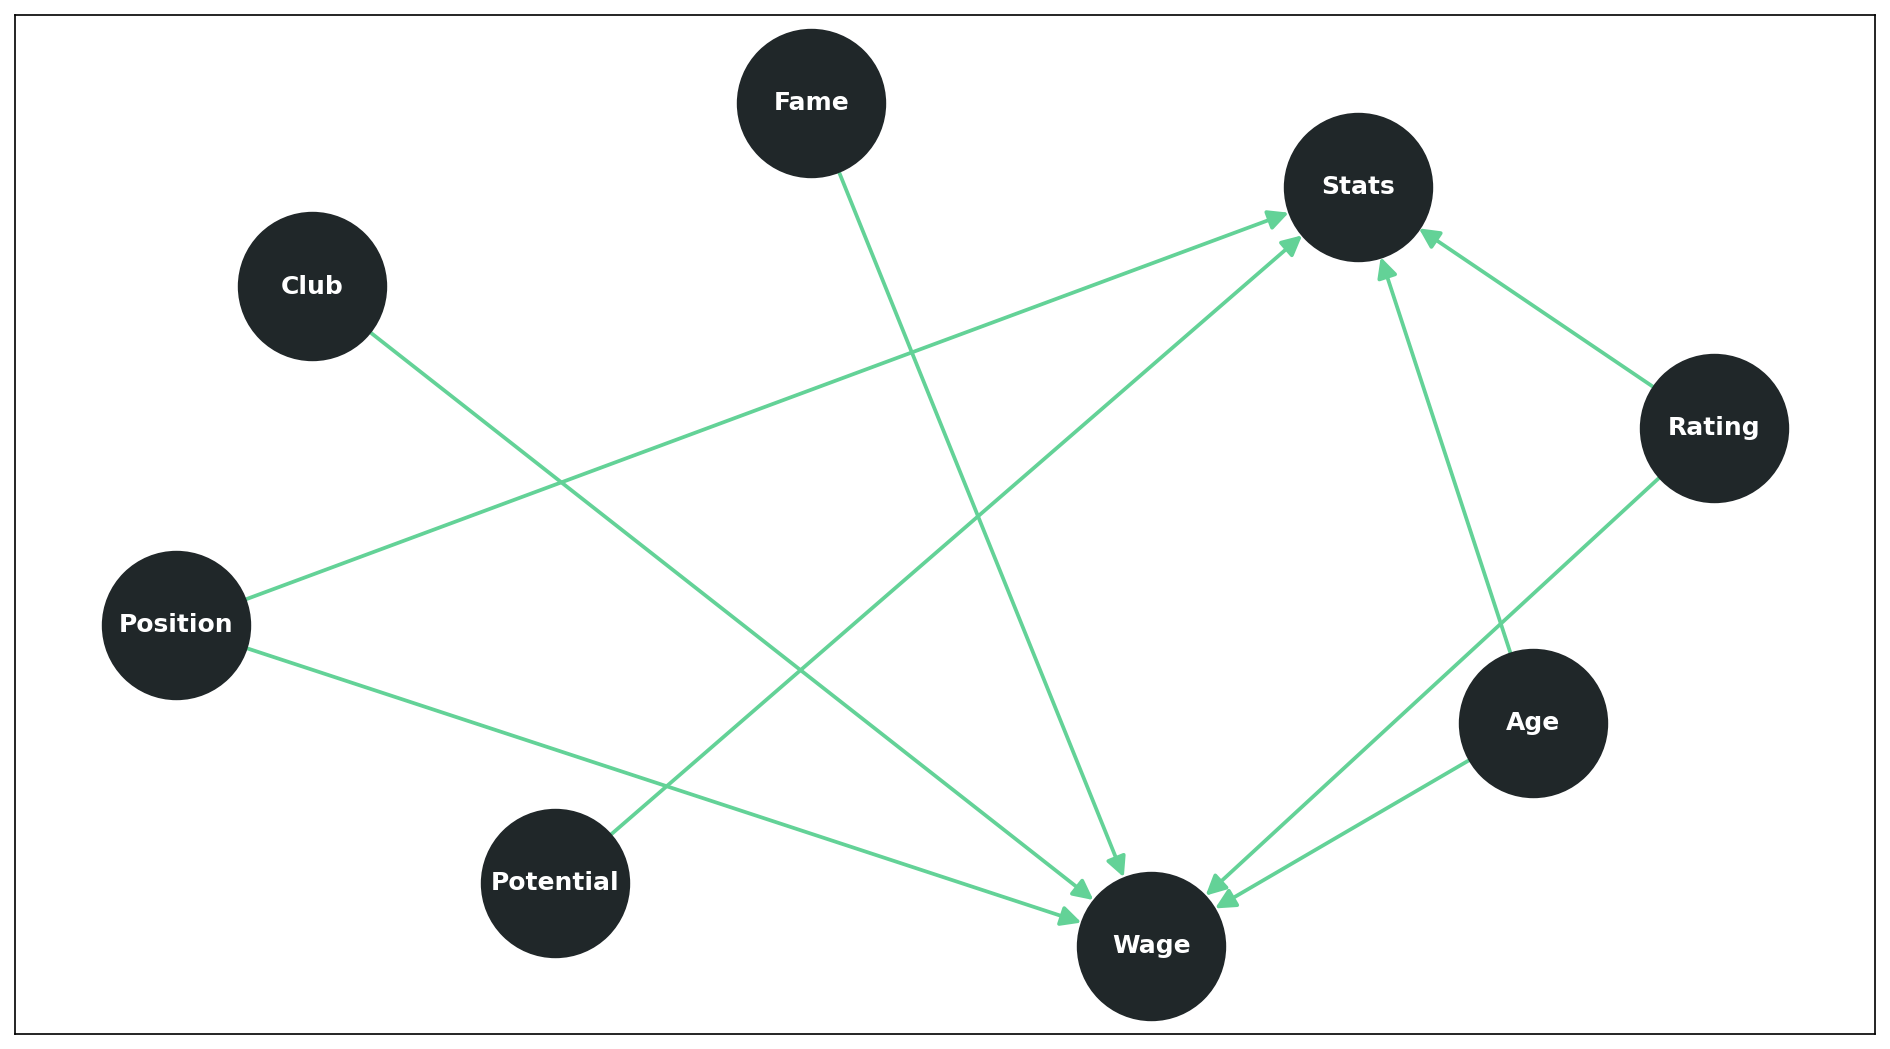

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianModel

plt.figure(figsize=(16,9), dpi=150)
generalized_model = BayesianModel([("Age", "Stats"),("Position", "Stats"), ("Rating", "Stats"), ("Potential", "Stats"),("Age", "Wage"),("Position", "Wage"),("Fame", "Wage"), ("Rating", "Wage"), ("Club", "Wage")]) 
nx.draw_networkx(generalized_model, with_labels=True, node_size = 5000,node_color="#202729",font_color="white", edge_color="#63D297", width=1.8, font_weight="bold", arrowsize=20)
plt.show()

In [16]:
generalized_model.get_independencies()

(Age _|_ Fame, Position, Rating, Club, Potential)
(Age _|_ Fame, Club | Stats)
(Age _|_ Potential | Wage)
(Age _|_ Fame, Potential, Club, Position | Rating)
(Age _|_ Club, Potential, Rating, Position | Fame)
(Age _|_ Fame, Potential, Rating, Position | Club)
(Age _|_ Fame, Club, Potential, Rating | Position)
(Age _|_ Fame, Club, Rating, Position | Potential)
(Age _|_ Fame, Club | Stats, Rating)
(Age _|_ Club | Fame, Stats)
(Age _|_ Fame | Stats, Club)
(Age _|_ Fame, Club | Stats, Position)
(Age _|_ Fame, Club | Stats, Potential)
(Age _|_ Potential | Wage, Rating)
(Age _|_ Potential | Fame, Wage)
(Age _|_ Potential | Wage, Club)
(Age _|_ Potential | Wage, Position)
(Age _|_ Potential, Club, Position | Fame, Rating)
(Age _|_ Fame, Potential, Position | Club, Rating)
(Age _|_ Fame, Potential, Club | Rating, Position)
(Age _|_ Fame, Club, Position | Potential, Rating)
(Age _|_ Potential, Rating, Position | Fame, Club)
(Age _|_ Club, Potential, Rating | Fame, Position)
(Age _|_ Club, Rating

## Data Exploration

In [17]:
def chiSquareTest(v1, v2):
    cross_table = pd.crosstab(
        df[v1],
        df[v2]
    )
    result = scipy.stats.chi2_contingency(cross_table)[1]
    if result < 0.05:
      print(v1 + " and " + v2 + " are independent")
    else:
      print(v1 + " and " + v2 + " are dependent")

  #  (Age _|_ Position, Overall, Potential, Club)
# (Position _|_ Age, Overall, Potential, Club)
# Club _|_ Age, Position, Potential, Stats, Overall, Fame)
# (Overall _|_ Age, Club, Potential, Position)

In [18]:
chiSquareTest("age", "player_positions")
chiSquareTest("age", "overall")
chiSquareTest("age", "potential")
chiSquareTest("age", "club_tier")
chiSquareTest("player_positions", "overall")
chiSquareTest("player_positions", "potential")
chiSquareTest("player_positions", "club_tier")
# (Fame _|_ Club)
chiSquareTest("international_reputation", "club_tier")
chiSquareTest("club_tier", "potential")
chiSquareTest("club_tier", "overall")
chiSquareTest("overall", "age")
chiSquareTest("overall", "potential")





age and player_positions are independent
age and overall are independent
age and potential are independent
age and club_tier are independent
player_positions and overall are independent
player_positions and potential are independent
player_positions and club_tier are independent
international_reputation and club_tier are independent
club_tier and potential are independent
club_tier and overall are independent
overall and age are independent
overall and potential are independent


In [19]:
# chiSquareTest("attacking_crossing", "joined")
chiSquareTest("height_cm", "work_rate")

height_cm and work_rate are independent


## Model Building & Training

### Build Model & Fit Data in PGMPY to Obtain CPD Tables

In [20]:
edges = set()
factors = set()

# edges pointing to player stats
for start in ["age", "player_positions", "overall", "potential"]:
    factors.add(start)
    for end in stats:
        factors.add(end)
        edges.add((start, end))

# edges pointing to moneytary values
for start in ["age", "player_positions", "club_tier", "international_reputation", "overall"]:
    factors.add(start)
    for end in moneytary_values:
        factors.add(end)
        edges.add((start, end))

# compile and train model
model = BayesianModel(edges)
model.fit(df[factors])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Rebuild Model in Pyro for Intervention Using CPDs Obtained in PGMPY

In [21]:
# #Codes For Generating Pyro Model 
# for node in stats:
#     variables = model.get_cpds(node).variables
#     variables[0] = ':'
#     print(f"{node} = pyro.sample('{node}', dist.Categorical(torch.tensor(model.get_cpds('{node}').values[{', '.join(variables)}])))")


In [22]:
def pyro_model():
    # Player Info
    age = pyro.sample('age', dist.Categorical(torch.tensor(model.get_cpds('age').values[:])))
    club_tier = pyro.sample('club_tier', dist.Categorical(torch.tensor(model.get_cpds('club_tier').values[:])))
    player_positions = pyro.sample('player_positions', dist.Categorical(torch.tensor(model.get_cpds('player_positions').values[:])))
    international_reputation = pyro.sample('international_reputation', dist.Categorical(torch.tensor(model.get_cpds('international_reputation').values[:])))
    
    # Player Ratings
    potential = pyro.sample('potential', dist.Categorical(torch.tensor(model.get_cpds('potential').values[:])))
    overall = pyro.sample('overall', dist.Categorical(torch.tensor(model.get_cpds('overall').values[:])))

    # Moneytary Values
    wage_eur = pyro.sample('wage_eur', dist.Categorical(torch.tensor(model.get_cpds('wage_eur').values[:, age, club_tier, international_reputation, overall, player_positions])))

    # Player Stats
    pace = pyro.sample('pace', dist.Categorical(torch.tensor(model.get_cpds('pace').values[:, age, overall, player_positions, potential])))
    dribbling = pyro.sample('dribbling', dist.Categorical(torch.tensor(model.get_cpds('dribbling').values[:, age, overall, player_positions, potential])))
    defending = pyro.sample('defending', dist.Categorical(torch.tensor(model.get_cpds('defending').values[:, age, overall, player_positions, potential])))
    attacking_crossing = pyro.sample('attacking_crossing', dist.Categorical(torch.tensor(model.get_cpds('attacking_crossing').values[:, age, overall, player_positions, potential])))
    attacking_finishing = pyro.sample('attacking_finishing', dist.Categorical(torch.tensor(model.get_cpds('attacking_finishing').values[:, age, overall, player_positions, potential])))
    attacking_heading_accuracy = pyro.sample('attacking_heading_accuracy', dist.Categorical(torch.tensor(model.get_cpds('attacking_heading_accuracy').values[:, age, overall, player_positions, potential])))
    attacking_short_passing = pyro.sample('attacking_short_passing', dist.Categorical(torch.tensor(model.get_cpds('attacking_short_passing').values[:, age, overall, player_positions, potential])))
    attacking_volleys = pyro.sample('attacking_volleys', dist.Categorical(torch.tensor(model.get_cpds('attacking_volleys').values[:, age, overall, player_positions, potential])))
    skill_dribbling = pyro.sample('skill_dribbling', dist.Categorical(torch.tensor(model.get_cpds('skill_dribbling').values[:, age, overall, player_positions, potential])))
    skill_curve = pyro.sample('skill_curve', dist.Categorical(torch.tensor(model.get_cpds('skill_curve').values[:, age, overall, player_positions, potential])))
    skill_fk_accuracy = pyro.sample('skill_fk_accuracy', dist.Categorical(torch.tensor(model.get_cpds('skill_fk_accuracy').values[:, age, overall, player_positions, potential])))
    skill_long_passing = pyro.sample('skill_long_passing', dist.Categorical(torch.tensor(model.get_cpds('skill_long_passing').values[:, age, overall, player_positions, potential])))
    skill_ball_control = pyro.sample('skill_ball_control', dist.Categorical(torch.tensor(model.get_cpds('skill_ball_control').values[:, age, overall, player_positions, potential])))
    movement_acceleration = pyro.sample('movement_acceleration', dist.Categorical(torch.tensor(model.get_cpds('movement_acceleration').values[:, age, overall, player_positions, potential])))
    movement_sprint_speed = pyro.sample('movement_sprint_speed', dist.Categorical(torch.tensor(model.get_cpds('movement_sprint_speed').values[:, age, overall, player_positions, potential])))
    movement_agility = pyro.sample('movement_agility', dist.Categorical(torch.tensor(model.get_cpds('movement_agility').values[:, age, overall, player_positions, potential])))
    movement_reactions = pyro.sample('movement_reactions', dist.Categorical(torch.tensor(model.get_cpds('movement_reactions').values[:, age, overall, player_positions, potential])))
    movement_balance = pyro.sample('movement_balance', dist.Categorical(torch.tensor(model.get_cpds('movement_balance').values[:, age, overall, player_positions, potential])))
    power_shot_power = pyro.sample('power_shot_power', dist.Categorical(torch.tensor(model.get_cpds('power_shot_power').values[:, age, overall, player_positions, potential])))
    power_jumping = pyro.sample('power_jumping', dist.Categorical(torch.tensor(model.get_cpds('power_jumping').values[:, age, overall, player_positions, potential])))
    power_stamina = pyro.sample('power_stamina', dist.Categorical(torch.tensor(model.get_cpds('power_stamina').values[:, age, overall, player_positions, potential])))
    power_strength = pyro.sample('power_strength', dist.Categorical(torch.tensor(model.get_cpds('power_strength').values[:, age, overall, player_positions, potential])))
    power_long_shots = pyro.sample('power_long_shots', dist.Categorical(torch.tensor(model.get_cpds('power_long_shots').values[:, age, overall, player_positions, potential])))
    mentality_aggression = pyro.sample('mentality_aggression', dist.Categorical(torch.tensor(model.get_cpds('mentality_aggression').values[:, age, overall, player_positions, potential])))
    mentality_interceptions = pyro.sample('mentality_interceptions', dist.Categorical(torch.tensor(model.get_cpds('mentality_interceptions').values[:, age, overall, player_positions, potential])))
    mentality_positioning = pyro.sample('mentality_positioning', dist.Categorical(torch.tensor(model.get_cpds('mentality_positioning').values[:, age, overall, player_positions, potential])))
    mentality_vision = pyro.sample('mentality_vision', dist.Categorical(torch.tensor(model.get_cpds('mentality_vision').values[:, age, overall, player_positions, potential])))
    mentality_penalties = pyro.sample('mentality_penalties', dist.Categorical(torch.tensor(model.get_cpds('mentality_penalties').values[:, age, overall, player_positions, potential])))
    mentality_composure = pyro.sample('mentality_composure', dist.Categorical(torch.tensor(model.get_cpds('mentality_composure').values[:, age, overall, player_positions, potential])))
    defending_marking = pyro.sample('defending_marking', dist.Categorical(torch.tensor(model.get_cpds('defending_marking').values[:, age, overall, player_positions, potential])))
    defending_standing_tackle = pyro.sample('defending_standing_tackle', dist.Categorical(torch.tensor(model.get_cpds('defending_standing_tackle').values[:, age, overall, player_positions, potential])))
    defending_sliding_tackle = pyro.sample('defending_sliding_tackle', dist.Categorical(torch.tensor(model.get_cpds('defending_sliding_tackle').values[:, age, overall, player_positions, potential])))
    goalkeeping_diving = pyro.sample('goalkeeping_diving', dist.Categorical(torch.tensor(model.get_cpds('goalkeeping_diving').values[:, age, overall, player_positions, potential])))
    goalkeeping_handling = pyro.sample('goalkeeping_handling', dist.Categorical(torch.tensor(model.get_cpds('goalkeeping_handling').values[:, age, overall, player_positions, potential])))
    goalkeeping_kicking = pyro.sample('goalkeeping_kicking', dist.Categorical(torch.tensor(model.get_cpds('goalkeeping_kicking').values[:, age, overall, player_positions, potential])))
    goalkeeping_positioning = pyro.sample('goalkeeping_positioning', dist.Categorical(torch.tensor(model.get_cpds('goalkeeping_positioning').values[:, age, overall, player_positions, potential])))
    goalkeeping_reflexes = pyro.sample('goalkeeping_reflexes', dist.Categorical(torch.tensor(model.get_cpds('goalkeeping_reflexes').values[:, age, overall, player_positions, potential])))

pyro_model()

## Intervention Exploration

In [23]:
def showEffects(model, intervention_method, X, effect_node, effect_labels, title, x_label, y_label='Percentage', num_samples=500, gap=0.2, figsize=(10,6), dpi=100):
    experiment_names = []
    conditioned_models = []

    for name, conditions in X.items():
        experiment_names.append(name)
        conditioned_models.append(intervention_method(model, conditions))

    marginals = [EmpiricalMarginal(Importance(conditioned, num_samples=num_samples).run(), effect_node) for conditioned in conditioned_models]
    samples = [[marginal().item() for _ in range(200)] for marginal in marginals]

    width = (1-gap) / len(samples)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111)

    for i, sample in enumerate(samples):
        unique, counts = np.unique(sample, return_counts=True)
        ax.bar(unique+(i+0.5)*width, counts/num_samples, width, label=experiment_names[i])

    plt.xticks(unique + (1-gap)/2, effect_labels if effect_labels != None else np.arange(len(unique)))
    plt.legend(loc='best')
    plt.xlabel(x_label)
    plt.ylabel('Counts')
    plt.title(title)
    plt.show()





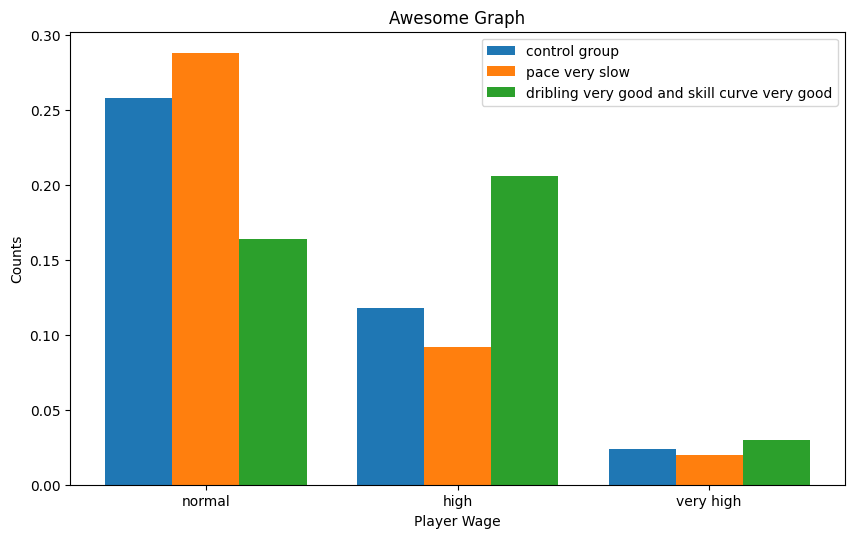

In [24]:

showEffects(
    model = pyro.do(pyro_model, {'age': torch.tensor(2)}),
    intervention_method = pyro.condition,
    X = {
        'control group': {},
       'pace very slow': {'pace': torch.tensor(0)},
       'dribling very good and skill curve very good': {'dribbling': torch.tensor(3), 'skill_curve': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Awesome Graph',
    x_label = 'Player Wage'
)

In [25]:
# def showEffects(model, intervention_method, cause_node, effect_node, cause_values, cause_labels, effect_labels, num_samples=100, gap=0.2, figsize=(10,6), dpi=100):
#     conditioned_models = [intervention_method(model, {cause_node: torch.tensor(value)}) for value in cause_values]
#     marginals = [EmpiricalMarginal(Importance(conditioned, num_samples=num_samples).run(), effect_node) for conditioned in conditioned_models]
#     samples = [[marginal().item() for _ in range(200)] for marginal in marginals]

#     width = (1-gap) / len(samples)

#     fig = plt.figure(figsize=figsize, dpi=dpi)
#     ax = fig.add_subplot(111)
#     for i, sample in enumerate(samples):
#         unique, counts = np.unique(sample, return_counts=True)
#         ax.bar(unique+(i+0.5)*width, counts, width, label=cause_labels[i])

#     plt.xticks(unique + (1-gap)/2, effect_labels if effect_labels != None else np.arange(len(unique)))
#     plt.legend(loc='best')
#     plt.show()


In [26]:
def posterior_probs(model, cause, cause_value, effect, effect_value, n=10, intervention_method=pyro.do):
    manipulated = intervention_method(model, {cause: torch.tensor(cause_value)})
    emp_marginal = EmpiricalMarginal(Importance(manipulated, num_samples=n).run(), effect)
    return math.exp(emp_marginal.log_prob(effect_value).item())

def average_causal_effect(cause, cause_value1, cause_value2, effect, effect_value, n=10, intervention_method=pyro.do, model = pyro_model):
    prob1 = posterior_probs(model, cause, cause_value1, effect, effect_value, n, intervention_method)
    prob2 = posterior_probs(model, cause, cause_value2, effect, effect_value, n, intervention_method)
    return prob1 - prob2


In [27]:
print(average_causal_effect('international_reputation', 0, 3, 'wage_eur', 2))
print(average_causal_effect('international_reputation', 0, 3, 'wage_eur', 1))
print(average_causal_effect('international_reputation', 0, 3, 'wage_eur', 0))

-0.19999999398584362
0.0
0.10000001528379676


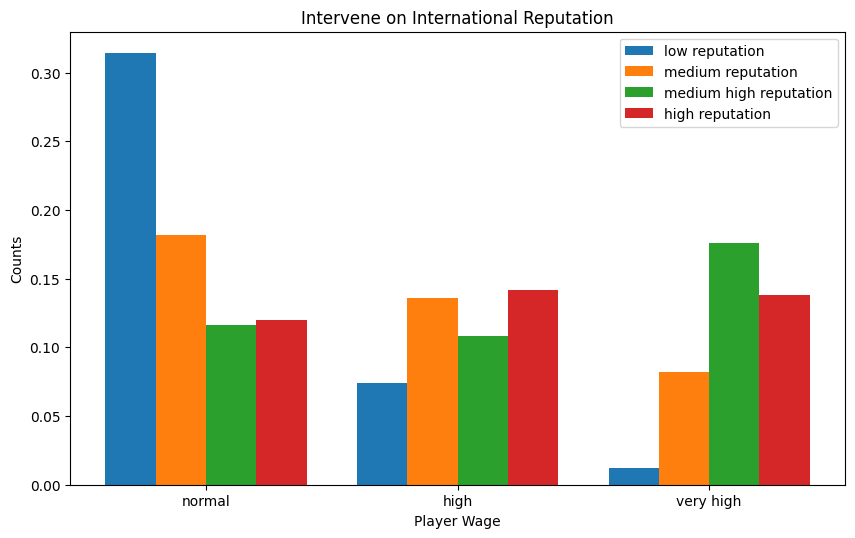

In [28]:


showEffects(
    model = pyro_model,
    intervention_method = pyro.do,
    X = {
       'low reputation': {'international_reputation': torch.tensor(0)},
       'medium reputation': {'international_reputation': torch.tensor(1)},
       'medium high reputation': {'international_reputation': torch.tensor(2)},
       'high reputation': {'international_reputation': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on International Reputation',
    x_label = 'Player Wage'
)

**Result Interpretation**: When intervened on international reputation, players with high international reputation tends to have high wages. Morever, When intervened on player's potential score, the potential does not have a very obvious influence on the wages. This coincide with real world. The wages of a high-reputation super star tends to have more salaries. Some high potential players are not discovered yet, thus did not have a big different in salaries.

In [29]:
print(average_causal_effect('player_position', 0, 3, 'wage_eur', 2))
print(average_causal_effect('player_position', 0, 3, 'wage_eur', 1))
print(average_causal_effect('player_position', 0, 3, 'wage_eur', 0))

0.0
-0.09999999718338724
-0.4000000617828492


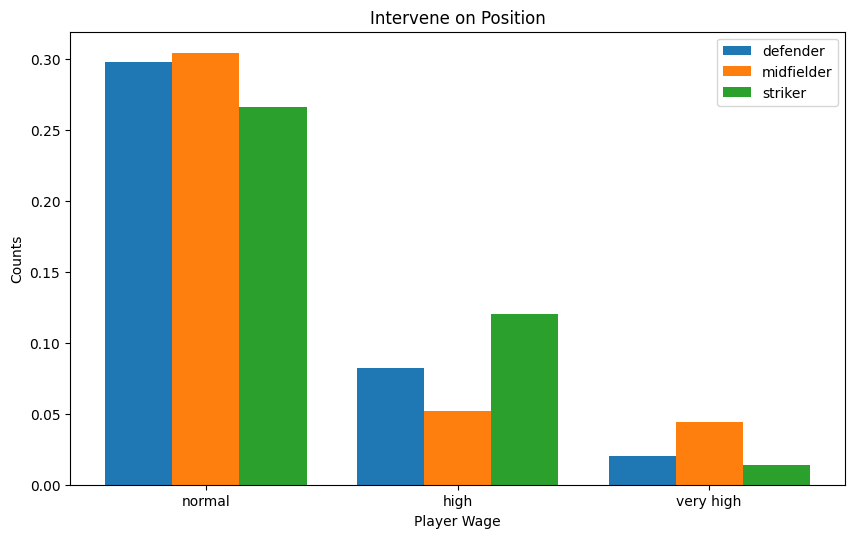

In [30]:


showEffects(
    model = pyro_model,
    intervention_method = pyro.do,
    X = {
       'defender': {'player_position': torch.tensor(0)},
       'midfielder': {'player_position': torch.tensor(1)},
       'striker': {'player_position': torch.tensor(2)},
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on Position',
    x_label = 'Player Wage'
)

In [31]:
eff1 = average_causal_effect('attacking_finishing', 0, 3, 'wage_eur', 0)
eff2 = average_causal_effect('attacking_crossing', 0, 3, 'wage_eur', 0)
eff3 = average_causal_effect('attacking_crossing', 0, 3, 'wage_eur', 0) 
print(average_causal_effect('attacking_finishing', 0, 3, 'wage_eur', 0))
print(average_causal_effect('attacking_crossing', 0, 3, 'wage_eur', 0))
print(average_causal_effect('goal_keeping_diving', 0, 3, 'wage_eur', 0))


0.20000004919069503
0.20000004919069503
0.10000002945368858


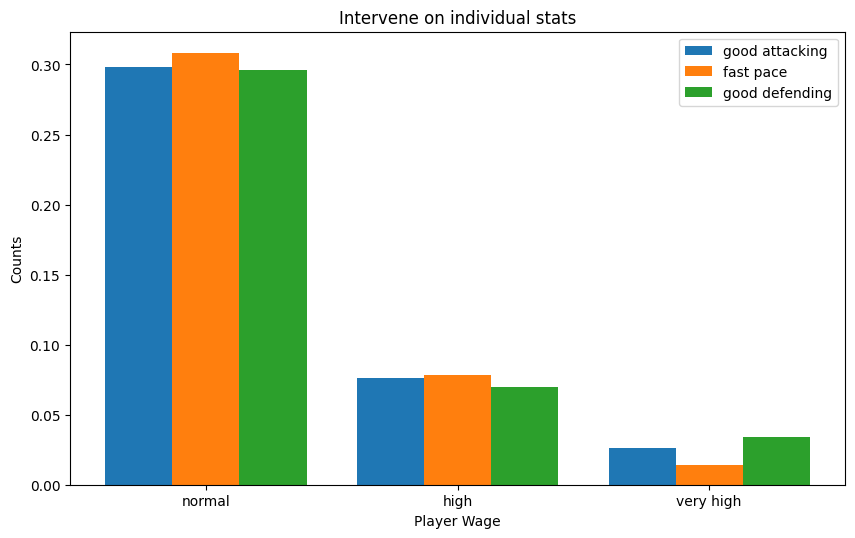

In [32]:
showEffects(
    model = pyro_model,
    intervention_method = pyro.do,
    X = {
       'good attacking': {'attacking_finishing': torch.tensor(3)},
       'fast pace': {'pace': torch.tensor(1)},
       'good defending': {'defending': torch.tensor(2)},
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on individual stats',
    x_label = 'Player Wage'
)

**Result Interpretaion:** Intervened on an individual player's statistic does not have a significant effect on player's wages.

In [33]:
print(average_causal_effect('age', 0, 3, 'wage_eur', 0))
print(average_causal_effect('age', 0, 3, 'wage_eur', 1))
print(average_causal_effect('age', 0, 3, 'wage_eur', 2))

0.10000001973700645
-0.10000000237175166
0.0


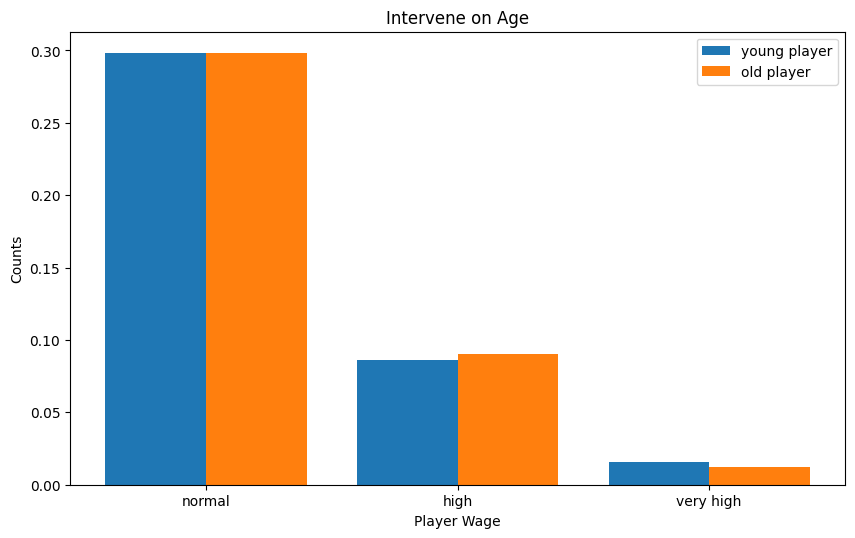

In [34]:
showEffects(
    model = pyro_model,
    intervention_method = pyro.do,
    X = {
       'young player': {'age': torch.tensor(0)},
       'old player': {'age': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on Age',
    x_label = 'Player Wage'
)

**Result Interpretation:** Intervened on age, we can see the causal effect of age on wage. Based on the above result, age had a positive effect on the low wage and had a negative effect on the high wage. Older players tends to have higher salary.

In [35]:
print(average_causal_effect('club_tier', 0, 3, 'wage_eur', 0))
print(average_causal_effect('club_tier', 0, 3, 'wage_eur', 1))
print(average_causal_effect('club_tier', 0, 3, 'wage_eur', 2))

-0.3000000323291606
-0.09999998647226599
-0.09999999718338724


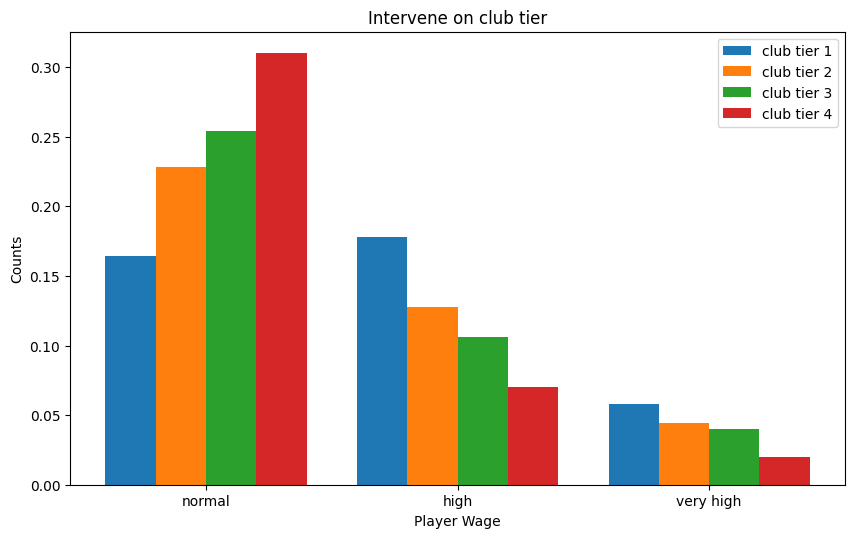

In [36]:
showEffects(
    model = pyro_model,
    intervention_method = pyro.do,
    X = {
       'club tier 1': {'club_tier': torch.tensor(0)},
       'club tier 2': {'club_tier': torch.tensor(1)},
       'club tier 3': {'club_tier': torch.tensor(2)},
       'club tier 4': {'club_tier': torch.tensor(3)},
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on club tier',
    x_label = 'Player Wage'
)

## **Conditional Exploration**

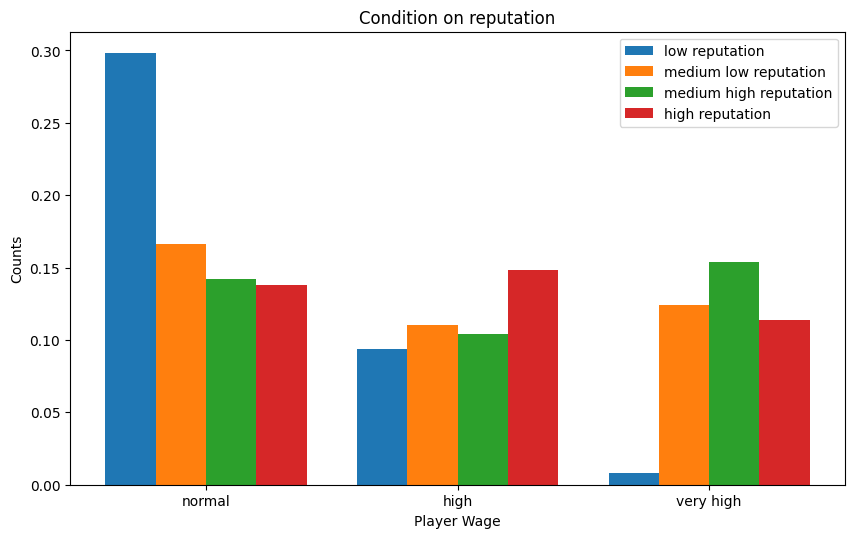

In [37]:

showEffects(
    model = pyro_model,
    intervention_method = pyro.condition,
    X = {
       'low reputation': {'international_reputation': torch.tensor(0)},
       'medium low reputation': {'international_reputation': torch.tensor(1)},
       'medium high reputation': {'international_reputation': torch.tensor(2)},
       'high reputation': {'international_reputation': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Condition on reputation',
    x_label = 'Player Wage'
)

**Result Interpretation**: When conditioned on group with lower international reputations (group 0) , the wages are more in the lower wage group (group 0); while conditioned on group with higher internation reputations (group 4), the wages are more in higher wage group (group 2). In other worlds, the average wages in high reputation group is larger than the low wages group.

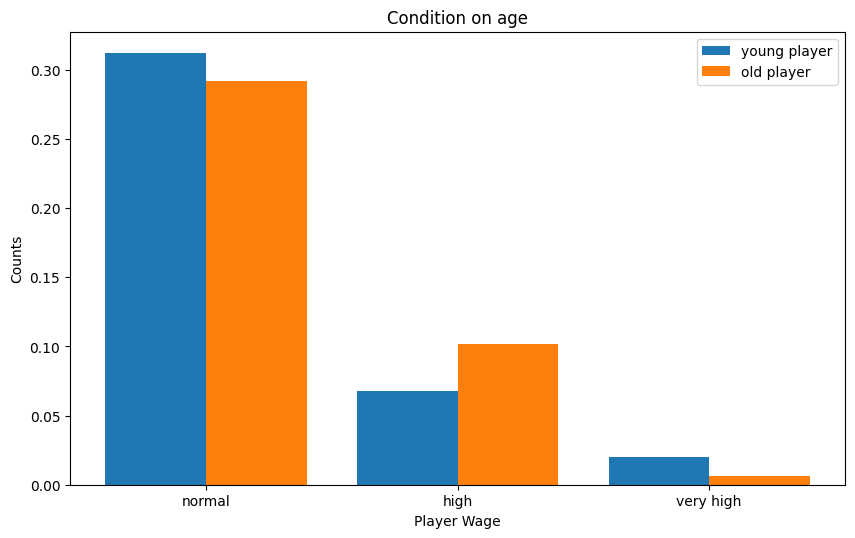

In [38]:
showEffects(
    model = pyro_model,
    intervention_method = pyro.condition,
    X = {
       'young player': {'age': torch.tensor(0)},
       'old player': {'age': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Condition on age',
    x_label = 'Player Wage'
)

**Result Interpretation:** conditioned on young player group and older player group, the distribution of wage does not have a big difference

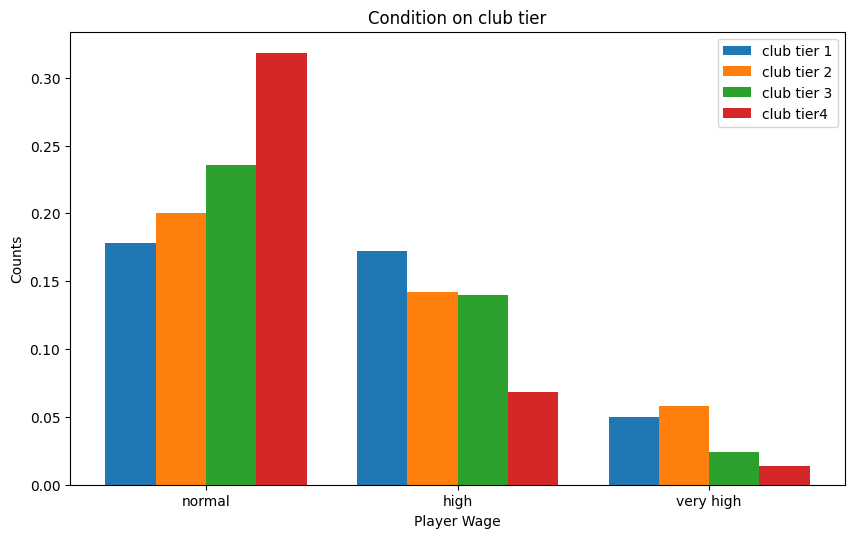

In [39]:
showEffects(
    model = pyro_model,
    intervention_method = pyro.condition,
    X = {
       'club tier 1': {'club_tier': torch.tensor(0)},
       'club tier 2': {'club_tier': torch.tensor(1)},
       'club tier 3': {'club_tier': torch.tensor(2)},
       'club tier4': {'club_tier': torch.tensor(3)}
    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Condition on club tier',
    x_label = 'Player Wage'
)

**Result Interpretation:** Conditioned on the higher tier club (tier 1), the wages are more in the high wage groups which are group 1 and group 2. While conditioned on club tier 4, more players have lower wage (group 0).

## **Intervention and Conditional Exploration**

### Causal Effect of Position on Wage Conditioned on Stats

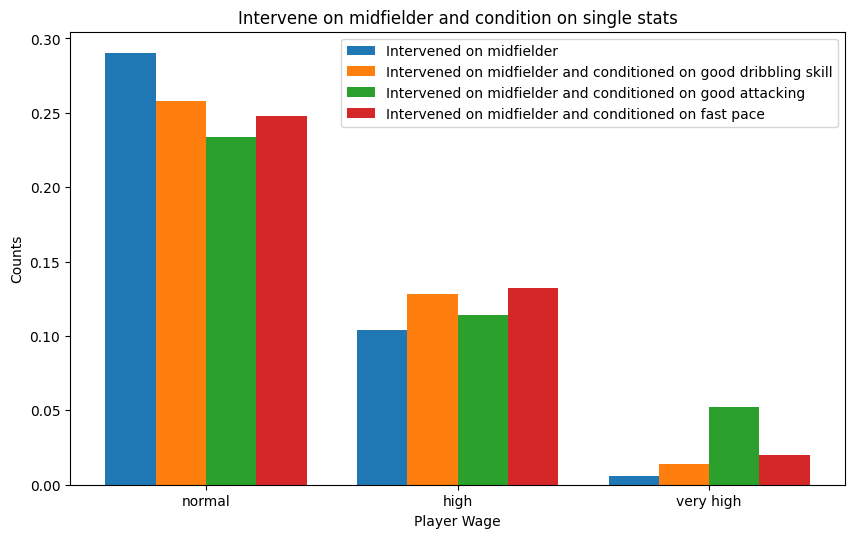

In [40]:
showEffects(
    model = pyro.do(pyro_model, {'position': torch.tensor(1)}),
    intervention_method = pyro.condition,
    X = {
        'Intervened on midfielder': {},
        'Intervened on midfielder and conditioned on good dribbling skill': {'dribbling': torch.tensor(3)},
        'Intervened on midfielder and conditioned on good attacking': {'attacking_finishing': torch.tensor(3)},
        'Intervened on midfielder and conditioned on fast pace': {'pace': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on midfielder and condition on single stats',
    x_label = 'Player Wage'
)


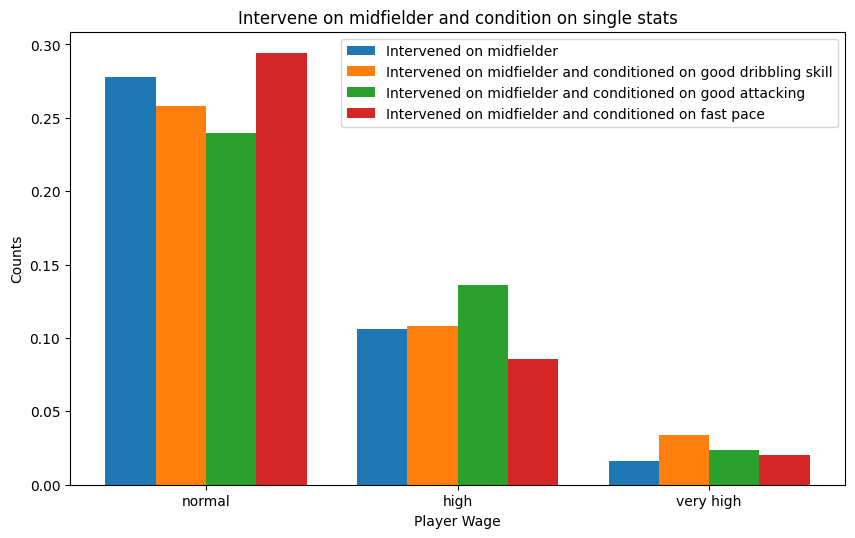

In [41]:
showEffects(
    model = pyro.do(pyro_model, {'position': torch.tensor(0)}),
    intervention_method = pyro.condition,
    X = {
        'Intervened on midfielder': {},
        'Intervened on midfielder and conditioned on good dribbling skill': {'dribbling': torch.tensor(3)},
        'Intervened on midfielder and conditioned on good attacking': {'attacking_finishing': torch.tensor(3)},
        'Intervened on midfielder and conditioned on fast pace': {'pace': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on midfielder and condition on single stats',
    x_label = 'Player Wage'
)


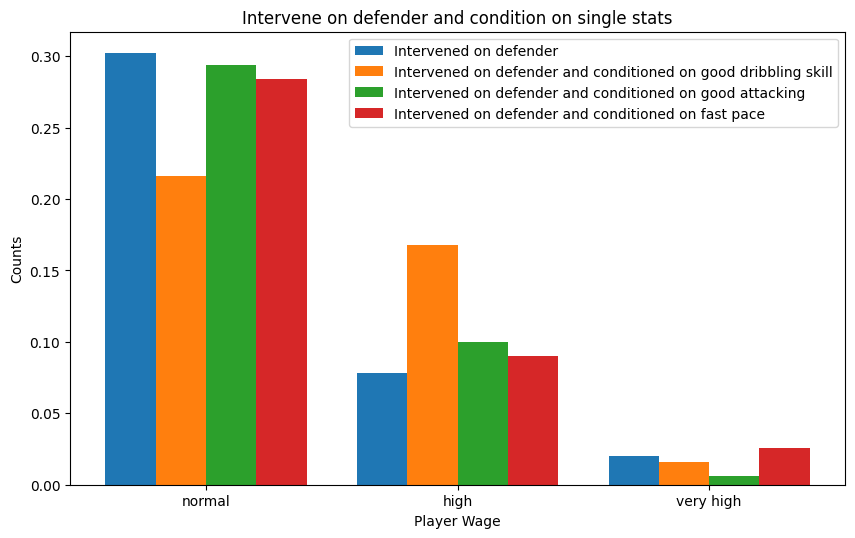

In [42]:
showEffects(
    model = pyro.do(pyro_model, {'position': torch.tensor(0)}),
    intervention_method = pyro.condition,
    X = {
        'Intervened on defender': {},
        'Intervened on defender and conditioned on good dribbling skill': {'dribbling': torch.tensor(3)},
        'Intervened on defender and conditioned on good attacking': {'attacking_finishing': torch.tensor(3)},
        'Intervened on defender and conditioned on fast pace': {'pace': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on defender and condition on single stats',
    x_label = 'Player Wage'
)


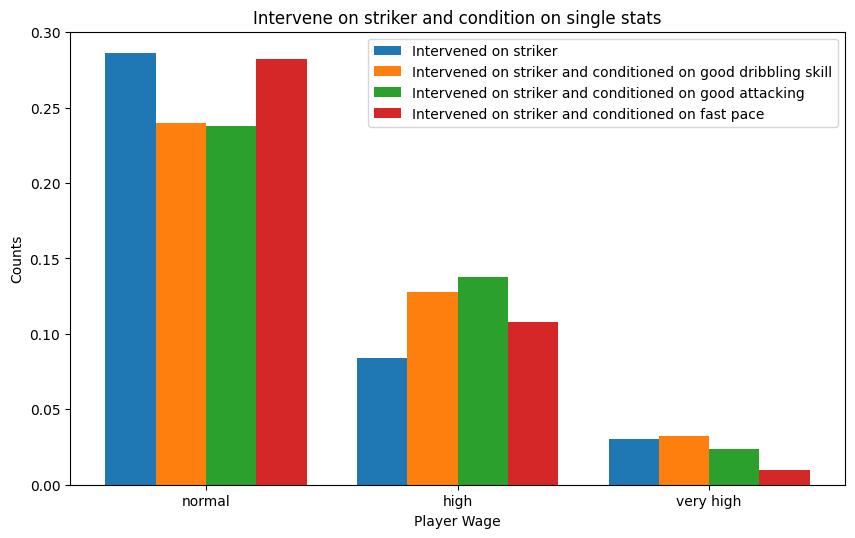

In [43]:
showEffects(
    model = pyro.do(pyro_model, {'position': torch.tensor(2)}),
    intervention_method = pyro.condition,
    X = {
        'Intervened on striker': {},
        'Intervened on striker and conditioned on good dribbling skill': {'dribbling': torch.tensor(3)},
        'Intervened on striker and conditioned on good attacking': {'attacking_finishing': torch.tensor(3)},
        'Intervened on striker and conditioned on fast pace': {'pace': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on striker and condition on single stats',
    x_label = 'Player Wage'
)


In [45]:
model_attacking = pyro.condition(pyro_model, {'attacking_finishing': torch.tensor(3)})
print(average_causal_effect('position', 0, 3, 'wage_eur', 0, model = model_attacking))
print(average_causal_effect('position', 0, 3, 'wage_eur', 1, model = model_attacking))
print(average_causal_effect('position', 0, 3, 'wage_eur', 2, model = model_attacking))

-0.10555421801999959
0.06988149018950535
-0.23763523798554714


In [46]:
model_pace = pyro.condition(pyro_model, {'pace': torch.tensor(0)})
print(average_causal_effect('position', 0, 3, 'wage_eur', 0, model = model_pace))
print(average_causal_effect('position', 0, 3, 'wage_eur', 1, model = model_pace))
print(average_causal_effect('position', 0, 3, 'wage_eur', 2, model = model_pace))

-0.2578033989117817
0.28600734288127927
0.09011903780165258


In [47]:
model_dribbling = pyro.condition(pyro_model, {'dribbling': torch.tensor(3)})
print(average_causal_effect('position', 0, 3, 'wage_eur', 0, model = model_dribbling))
print(average_causal_effect('position', 0, 3, 'wage_eur', 1, model = model_dribbling))
print(average_causal_effect('position', 0, 3, 'wage_eur', 2, model = model_dribbling))

0.3059620143785678
-0.04978491452187528
0.0


### Causal Effect of Overall on Wage Conditioned on Stats

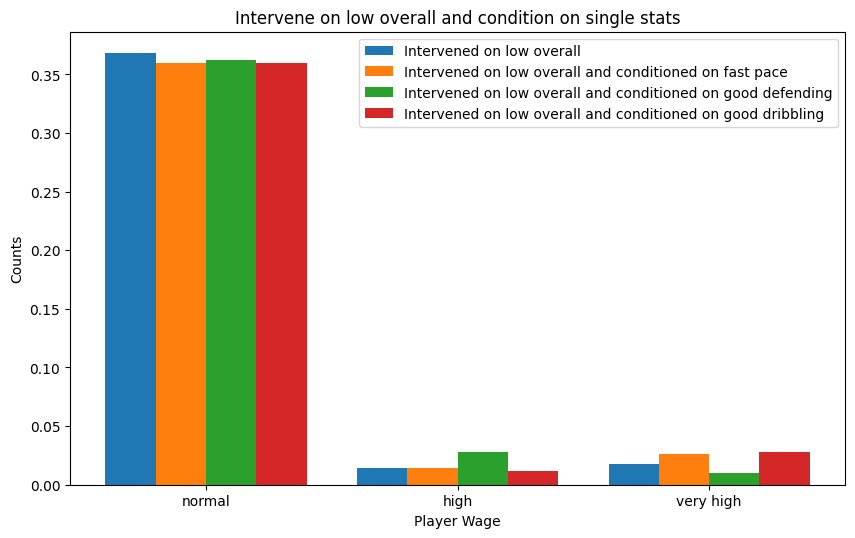

In [48]:
showEffects(
    model = pyro.do(pyro_model, {'overall': torch.tensor(0), }),
    intervention_method = pyro.condition,
    X = {
        'Intervened on low overall': {},
        'Intervened on low overall and conditioned on fast pace': {'pace': torch.tensor(3)},
        'Intervened on low overall and conditioned on good defending': {'defending': torch.tensor(3)},
        'Intervened on low overall and conditioned on good dribbling': {'attacking_crossing': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on low overall and condition on single stats',
    x_label = 'Player Wage'
)


### Causal Effect of Potential on Wage Conditioned on Stats

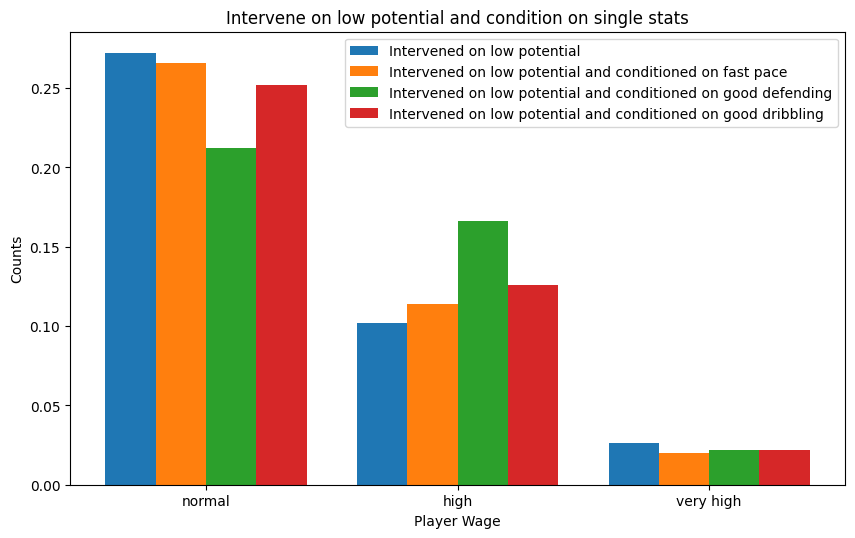

In [49]:
showEffects(
    model = pyro.do(pyro_model, {'potential': torch.tensor(0), }),
    intervention_method = pyro.condition,
    X = {
        'Intervened on low potential': {},
        'Intervened on low potential and conditioned on fast pace': {'pace': torch.tensor(3)},
        'Intervened on low potential and conditioned on good defending': {'defending': torch.tensor(3)},
        'Intervened on low potential and conditioned on good dribbling': {'attacking_crossing': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on low potential and condition on single stats',
    x_label = 'Player Wage'
)


### Causal Effect of Age on Wage Conditioned on Stats

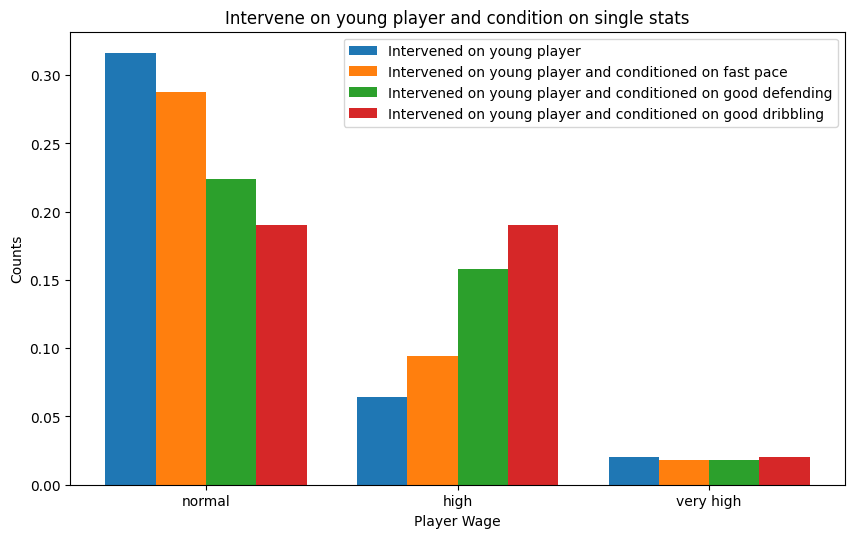

In [50]:
showEffects(
    model = pyro.do(pyro_model, {'age': torch.tensor(0), }),
    intervention_method = pyro.condition,
    X = {
        'Intervened on young player': {},
        'Intervened on young player and conditioned on fast pace': {'pace': torch.tensor(3)},
        'Intervened on young player and conditioned on good defending': {'defending': torch.tensor(3)},
        'Intervened on young player and conditioned on good dribbling': {'attacking_crossing': torch.tensor(3)},

    },
    effect_node = 'wage_eur',
    effect_labels = ('normal', 'high', 'very high'),
    title = 'Intervene on young player and condition on single stats',
    x_label = 'Player Wage'
)


## Summary

In our study, we explored the main factors that influenced the players' salaries. Based on our knowleges, we guessed a Bayesian model and fitted the model using plenty of data. We did pre-procession of the data including: categorize the club tier based on club names, categorize numeric factors like age, weights and so on, filters very small clubs with a threshold. Using all these processed data, we built a Bayesian model using 'pyro' package to explore the conditional and interventions on the main factors and visualize the result using barplots. We can see the model we built was very coincide with our knowledge and commonsense. Using this model, users can try intervention and conditions to study the causal effects between different factors. Our model also can help solve practical problems just like the questions I mentioned in the introduction that helping soccer club managers to leverage as a tool to evaluate player values.

## Reference


Data source : [ https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset ]